## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, Callable, List

In [2]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
!pwd

/home/xavi/Documents/CreditRisk/notebooks


In [4]:
file: Path = Path('/home/xavi/Documents/CreditRisk/data/curated/dataset.parquet')

In [5]:
df: pd.DataFrame = pd.read_parquet(file, engine='pyarrow')

### Depedent variable:

In [6]:
df['loan_status'].value_counts(dropna=False, normalize=True)

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [7]:
defaults: List[str] = [
    'Charged Off',
    'Late (31-120 days)',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

In [8]:
is_in_defaults: Callable  = defaults.__contains__

In [9]:
df['non_default'] = df['loan_status'].apply(lambda v: 0 if is_in_defaults(v) else 1)

In [10]:
df['zip_code'].dtype

dtype('int16')

### Indepent variables

#### Discrete variables

In [11]:
category_mask: pd.Series = df.dtypes == 'category'

In [12]:
categories: List[str] = df.dtypes[category_mask].index.to_list()

In [13]:
cat_df: pd.DataFrame = df[categories + ['non_default']].drop('issue_d', axis=1)

In [14]:
categories.remove('issue_d')
categories.remove('loan_status')

In [15]:
categories

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'policy_code',
 'application_type']

**WoE and IV calculation**:

In [16]:
def calculate_woe_iv(data:pd.DataFrame, variable:pd.Series, target:pd.Series, multilevel_index:bool = False, sort_by_woe: bool = True, aggfunc: Callable = len) -> pd.DataFrame:
    pivot = pd.pivot_table(data=data, index=variable, columns=target, aggfunc=aggfunc, fill_value=0, values=[])
    pivot['n_obs'] = pivot.apply(axis=1, func=np.sum)
    pivot['n_obs_rel'] = pivot['n_obs'] / pivot['n_obs'].sum()

    #add .00000005 to handle errors when calculating WoE (ln(0))
    pivot['bad_rel'] = (pivot[0] + .00000005) / pivot[0].sum()
    pivot['good_rel'] = (pivot[1] + .00000005) / pivot[1].sum()

    pivot['woe'] = np.log(pivot['good_rel']) - np.log(pivot['bad_rel'])

    if sort_by_woe:
        pivot = pivot.sort_values(by='woe', ascending=True)

    else:
        pivot = pivot.sort_index(ascending=True)
        
    pivot['good_rel_diff'] = pivot['good_rel'].diff().abs()
    pivot['bad_rel_diff'] = pivot['bad_rel'].diff().abs()
    pivot['woe_diff'] = pivot['woe'].diff().abs()
    pivot['accum_n_obs_rel'] = pivot['n_obs_rel'].cumsum()
    
    pivot['iv'] = ((pivot['good_rel'] - pivot['bad_rel']) * pivot['woe']).sum()
    
    if multilevel_index:
        pivot['variable'] = variable.name
        pivot = pivot.set_index(['variable', pivot.index])

    if sort_by_woe:
        return pivot.sort_values(by='woe', ascending=True)

    return pivot.sort_index(ascending=True)

In [17]:
def run_woe_iv(data:pd.DataFrame, independent_vars:List[str], dependent_var:str) -> pd.DataFrame:
    accum: pd.Dataframe = pd.DataFrame([])
    for v in independent_vars:
        result = calculate_woe_iv(data[[v, dependent_var]], data[v], data[dependent_var], multilevel_index=True)
        accum = pd.concat([accum, result], axis=0)

    return accum

In [18]:
calculate_woe_iv(cat_df, cat_df['grade'], cat_df['non_default'], multilevel_index=True)

non_default         0       1   n_obs  n_obs_rel   bad_rel  good_rel  \
variable grade                                                         
grade    G        924    2398    3322   0.007124  0.018129  0.005774   
         F       3192   10037   13229   0.028371  0.062628  0.024167   
         E       6964   28793   35757   0.076685  0.136635  0.069328   
         D      11848   65040   76888   0.164895  0.232460  0.156603   
         C      14384  110909  125293   0.268705  0.282216  0.267047   
         B      10759  126170  136929   0.293659  0.211093  0.303792   
         A       2897   71970   74867   0.160561  0.056840  0.173289   

non_default          woe  good_rel_diff  bad_rel_diff  woe_diff  \
variable grade                                                    
grade    G     -1.144166            NaN           NaN       NaN   
         F     -0.952214       0.018393      0.044499  0.191952   
         E     -0.678466       0.045161      0.074007  0.273748   
         D     -0.395001       0.087276      0.095825  0.283465   
         C     -0.055251       0.110443      0.049757  0.339750   
         B      0.364043       0.036745      0.071123  0.419294   
         A      1.114730       0.130503      0.154254  0.750686   

non_default     accum_n_obs_rel        iv  
variable grade                             
grade    G             0.007124  0.290782  
         F             0.035495  0.290782  
         E             0.112180  0.290782  
         D             0.277075  0.290782  
         C             0.545780  0.290782  
         B             0.839439  0.290782  
         A             1.000000  0.290782

In [19]:
woe_summary = run_woe_iv(data=cat_df, independent_vars=categories, dependent_var='non_default')

In [20]:
woe_summary.groupby(level=0)['iv'].max().sort_values(ascending=False).apply(lambda v: '{0}'.format(str(v)))

variable
sub_grade                 0.31518048388061826
grade                     0.29078213954153515
term                       0.0388598343886394
purpose                   0.03698019472315489
initial_list_status      0.024801321308154253
home_ownership            0.02169733320858703
verification_status      0.020831404234464192
addr_state               0.012672623763957586
emp_length              0.0048260242100888395
pymnt_plan             0.00012456255520646649
application_type        7.407096244268185e-25
policy_code             7.407096244268185e-25
Name: iv, dtype: object

**Plot WoE**:

In [119]:
def plot_woe(woe_series: pd.Series, labels: pd.Series | None = None):
    fig = plt.figure(figsize=(18, 6))

    style_dict = {
                  'xlabel': 'Categories',
                  'title': '{0}'.format(woe_series.name),
                 }
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    
    rotate = False
    if isinstance(woe_series.index.values[0], pd.Interval):
        x =  list(map(str, woe_series.index.values))
        rotate = True
        
    else:
        x = woe_series.index.values
        
    ax.plot(x, woe_series.values, color='red', marker='o', linestyle='--')

    if rotate:
        ax.set_xticks(np.arange(0, len(x)))
        ax.set_xticklabels(x, rotation = 90)
        
    if labels is not None:
        for (i, label), value in zip(enumerate(labels.values), woe_series.values) :
            ax.text(i, value + 0.1, label)
    
    return ax

<Axes: title={'center': 'woe'}, xlabel='Categories'>

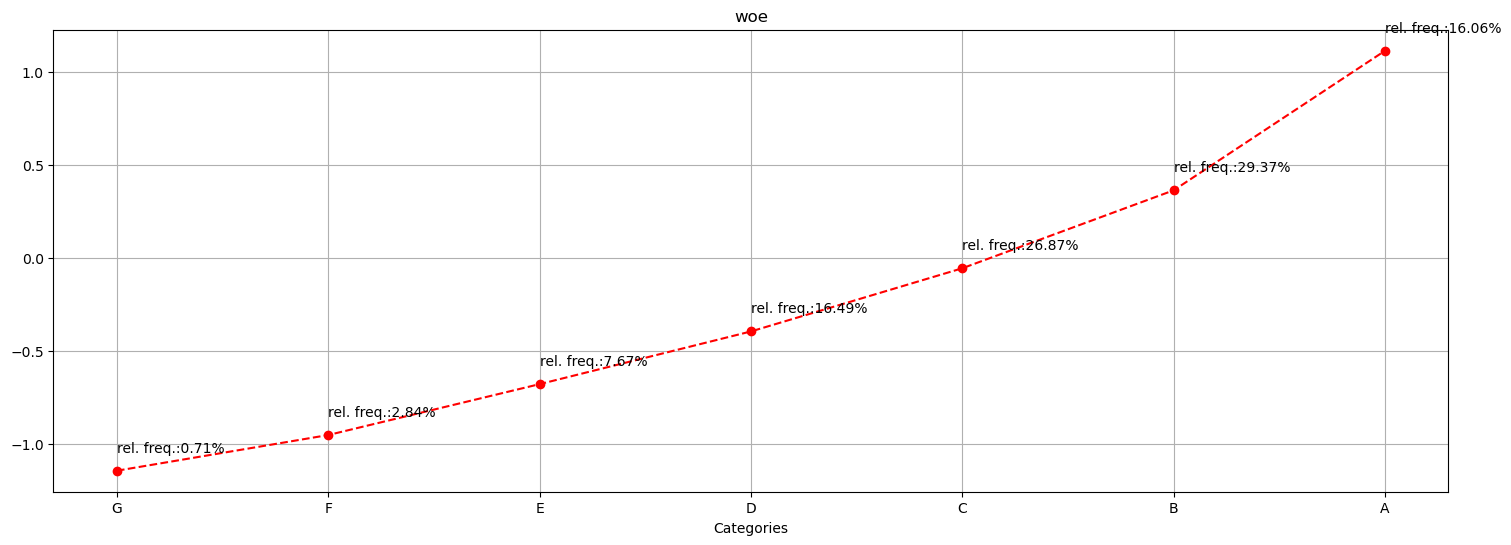

In [22]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{0:.2%}'.format(v)))

In [23]:
from collections.abc import Iterable
import abc

class Component(Iterable, abc.ABC):

    def __init__(self, *args, **kwargs):
        self.children = list()
        self._name: str = ''
    
    def add_child(self, element) -> 'Component':
        self.children.append(element)

        return self
        
    def remove_child(self, element) -> 'Component':
        self.children.append(element)

        return self

    def _str_leaves(self, indent: int = 0) -> str:
        initial_str: str = '|\t' * indent + f'|----{self.name}\n'
        for element in self:
            if isinstance(element, Component):
                initial_str += element._str_leaves(indent + 1)

            else:
                initial_str += '|\t' * (indent + 1) + f'|----{str(element)}\n'

        return initial_str
        
    @abc.abstractmethod
    def transform(self, *args, **kwargs) -> Any: pass

    @abc.abstractproperty
    def name(self) -> str: pass

    def __str__(self) -> str:
        return self._str_leaves(indent=0)


class Group(Component):

    def transform(self) -> Callable:
        return self.children.__contains__

    @property
    def name(self):
        return '_'.join(map(str, self.children))

    def extend_group(self, elements) -> Component:
        self.children.extend(elements)

        return self

    def __iter__(self):
        for value in self.children:
            yield value

class Interval(Component):

    def transform(self) -> Callable:
        return self.children[0].__contains__

    @property
    def name(self):
        return '_'.join(map(str, self.children))

    def __iter__(self):
        yield self.children[0]
        
class GroupedColumn(Group):

    def __init__(self, name: str, *args, **kwargs):
        Component.__init__(self, *args, **kwargs)
        self._name = name

    def transform(self, series: pd.Series) -> pd.DataFrame:
        df_dict: dict[str, pd.Series] = {}
        for group in self:
            df_dict[self.name + '_' + group.name] = series.apply(group.transform()).apply(int)
            
        return pd.DataFrame(df_dict)

    @property
    def name(self):
        return self._name

    def add_remainder(self, elements: List[str]) -> Component:
        new_elements = set(elements)
        for column in self:
            new_elements-= set(column.children)

        if new_elements:
            self.add_child(Group().extend_group(list(new_elements)))

        return self

    def add_one_category_groups(self, elements: List[str]) -> Component:
        for element in elements:
            self.add_child(Group().add_child(element))

        return self


class DataFrameTransform(Group):

    def transform(self, df: pd.DataFrame, remove_originals: bool = False) -> pd.DataFrame:
        for column in self:
            df = pd.concat([df, column.transform(df[column.name])], axis=1)
            if remove_originals:
                df = df.drop(column.name, axis=1)
            
        return df

    @property
    def name(self):
        return 'DataFrameTransform'

### Group Categories

Variables:
- Home ownership
- Grade
- State
- Verification status
- Purpose
- Initial List status

In [24]:
dft = DataFrameTransform()

**Grade**

In [25]:
grade_groups = GroupedColumn('grade')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

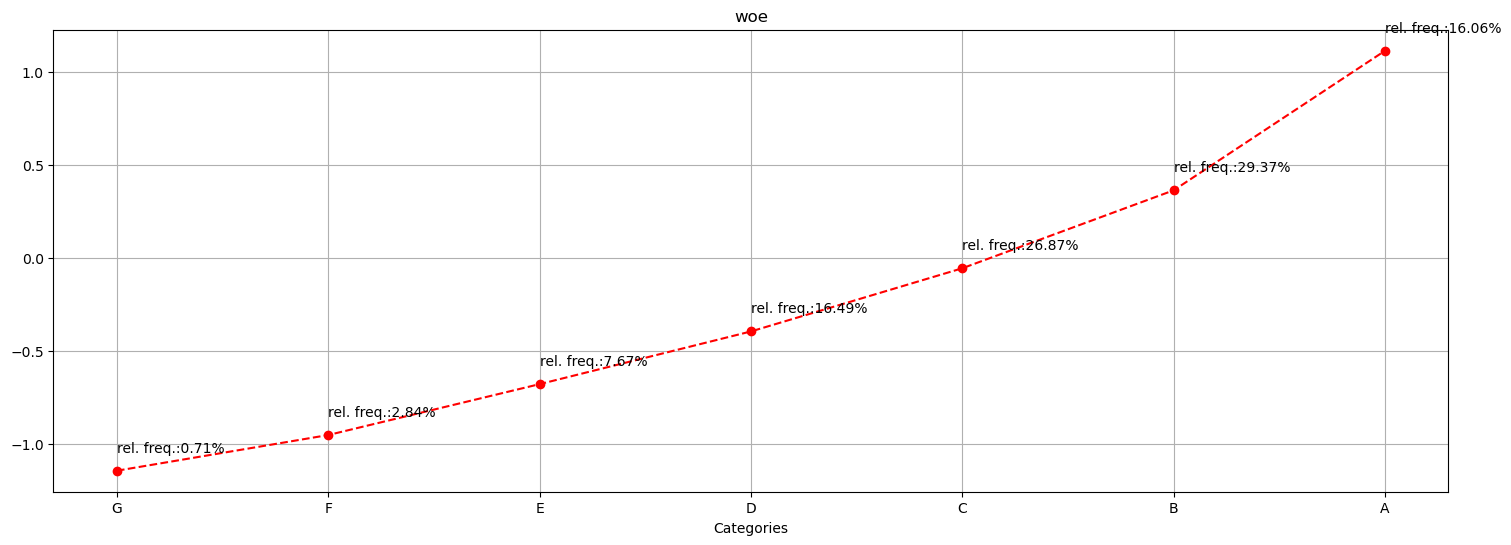

In [26]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [27]:
grade_groups.add_child(Group().extend_group(['G', 'F', 'E']))

In [28]:
grade_groups.add_one_category_groups(['D', 'C', 'B', 'A'])

In [29]:
print(grade_groups)

|----grade
|	|----G_F_E
|	|	|----G
|	|	|----F
|	|	|----E
|	|----D
|	|	|----D
|	|----C
|	|	|----C
|	|----B
|	|	|----B
|	|----A
|	|	|----A



In [30]:
dft.add_child(grade_groups)

**Home ownership**

In [31]:
owner_groups = GroupedColumn('home_ownership')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

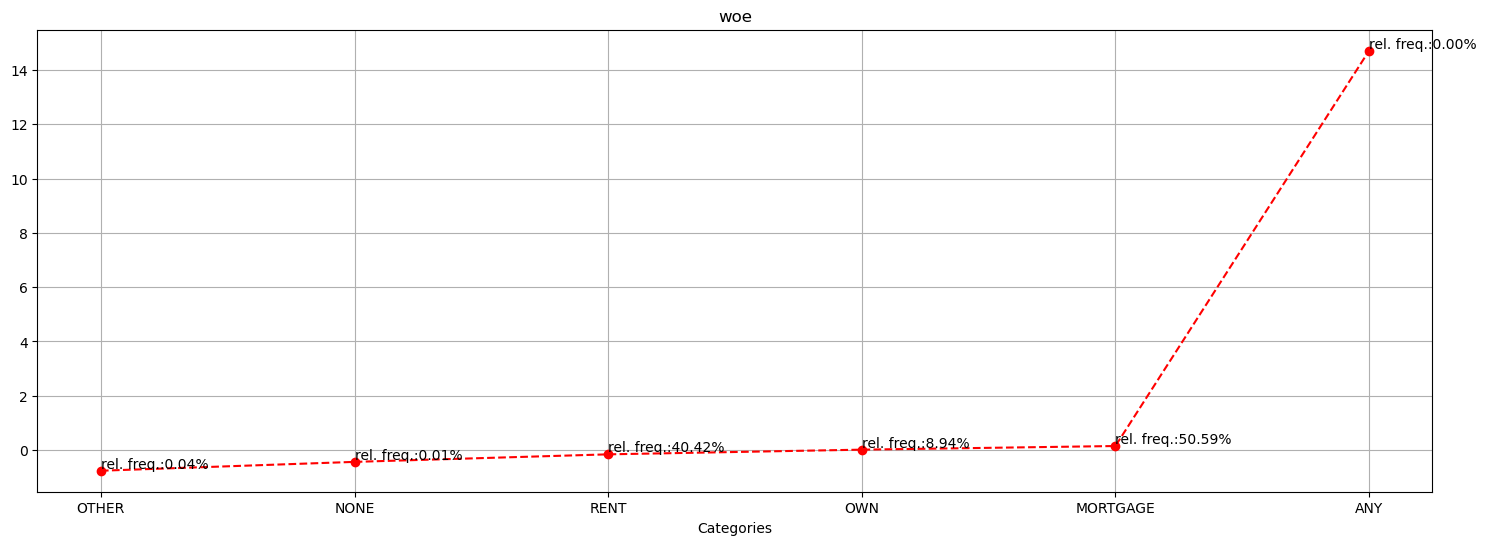

In [32]:
plot_woe(woe_summary.loc['home_ownership', :]['woe'], labels=woe_summary.loc['home_ownership', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [33]:
under_represented_n_risky = Group().add_child('OTHER').add_child('NONE').add_child('ANY').add_child('RENT')

In [34]:
owner_groups.add_child(under_represented_n_risky)

In [35]:
owner_groups.add_one_category_groups(['OWN', 'MORTGAGE'])

In [36]:
dft.add_child(owner_groups)
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE



**State**

In [37]:
states_groups = GroupedColumn('addr_state')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

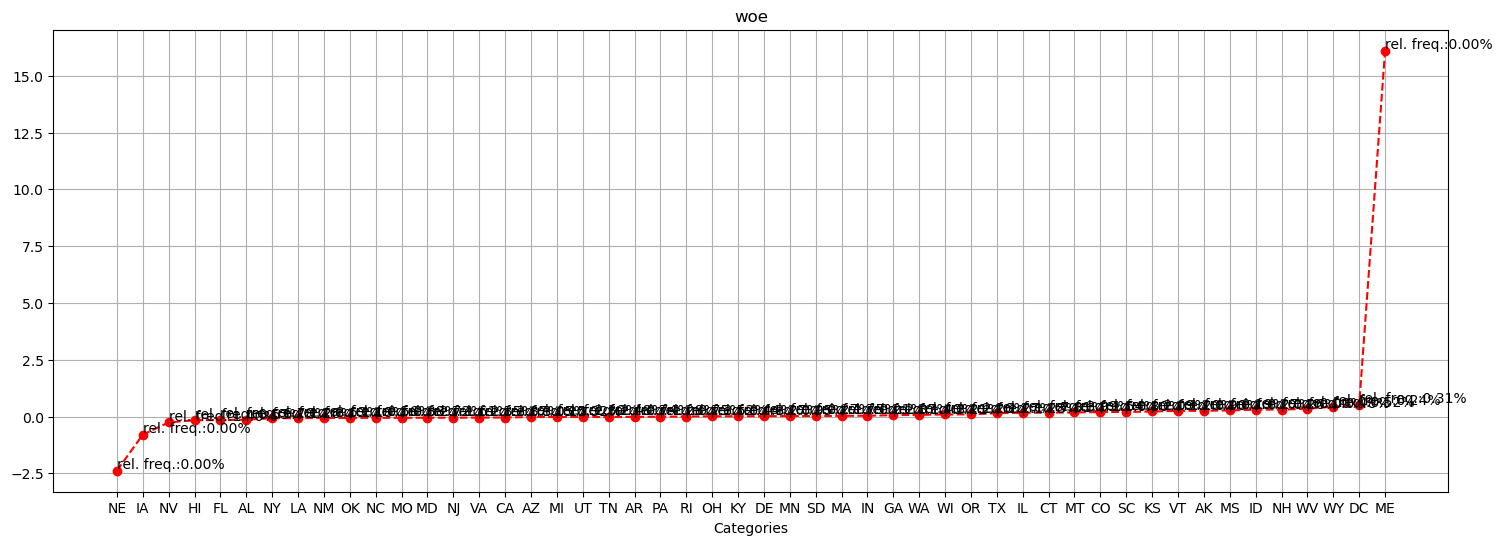

In [38]:
plot_woe(woe_summary.loc['addr_state', :]['woe'], labels=woe_summary.loc['addr_state', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [39]:
woe_summary.loc['addr_state', :]

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
NE,8,6,14,0.000030,1.569612e-04,0.000014,-2.385526,NaN,NaN,NaN,0.000030,0.012673
IA,3,11,14,0.000030,5.886046e-05,0.000026,-0.798561,0.000012,0.000098,1.586965,0.000060,0.012673
NV,894,5625,6519,0.013981,1.754042e-02,0.013544,-0.258574,0.013517,0.017482,0.539987,0.014041,0.012673
HI,314,2173,2487,0.005334,6.160728e-03,0.005232,-0.163373,0.008312,0.011380,0.095201,0.019374,0.012673
FL,3966,27671,31637,0.067849,7.781353e-02,0.066626,-0.155217,0.061394,0.071653,0.008156,0.087223,0.012673
AL,723,5130,5853,0.012552,1.418537e-02,0.012352,-0.138392,0.054274,0.063628,0.016825,0.099776,0.012673
NY,4701,35541,40242,0.086303,9.223434e-02,0.085576,-0.074932,0.073224,0.078049,0.063460,0.186079,0.012673
LA,640,4849,5489,0.011772,1.255690e-02,0.011675,-0.072784,0.073900,0.079677,0.002148,0.197851,0.012673
NM,299,2289,2588,0.005550,5.866426e-03,0.005511,-0.062417,0.006164,0.006690,0.010367,0.203401,0.012673
OK,475,3642,4117,0.008829,9.319573e-03,0.008769,-0.060871,0.003258,0.003453,0.001547,0.212231,0.012673


In [40]:
len(woe_summary.loc['addr_state', :])

50

<Axes: title={'center': 'woe'}, xlabel='Categories'>

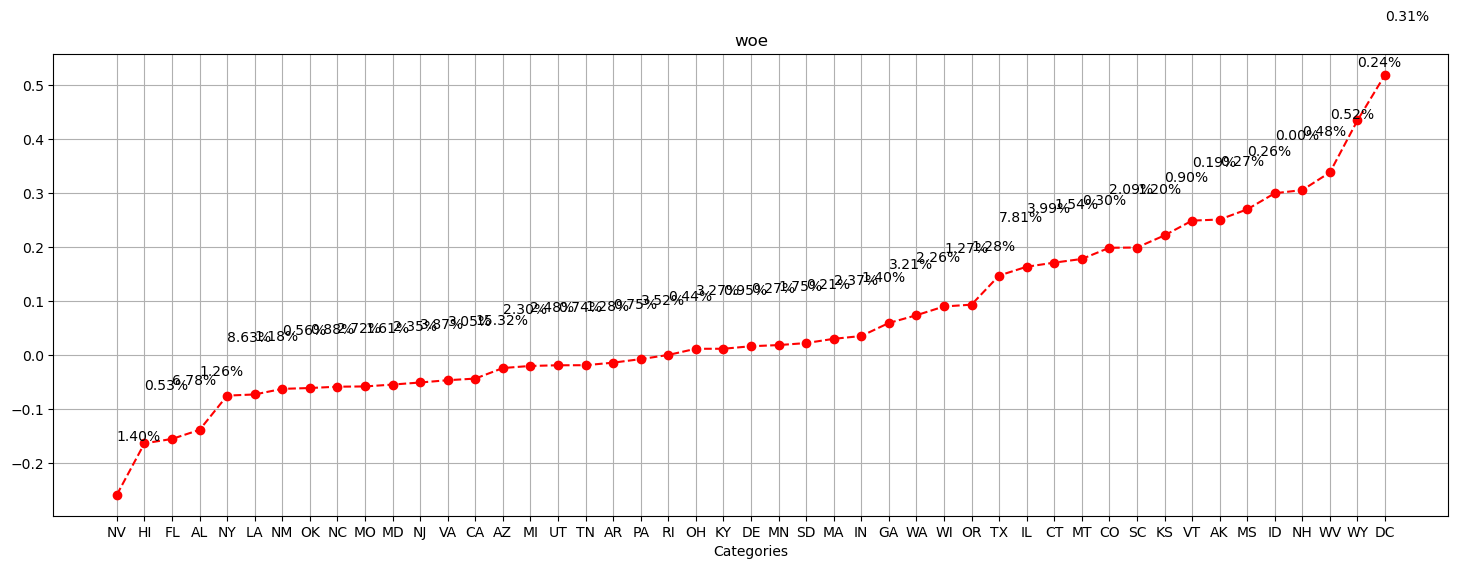

In [41]:
plot_woe(woe_summary.loc['addr_state', :].iloc[2:-1, :]['woe'],
         labels=woe_summary.loc['addr_state', :].iloc[2:-1, :]['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [42]:
states_groups.add_child(Group().extend_group(['NE', 'IA', 'ND', 'NV', 'HI', 'FL', 'AL']))\
            .add_child(Group().extend_group(['ID', 'NH', 'WV', 'WY', 'DC', 'ME'])) #best and underrepresented

<Axes: title={'center': 'woe'}, xlabel='Categories'>

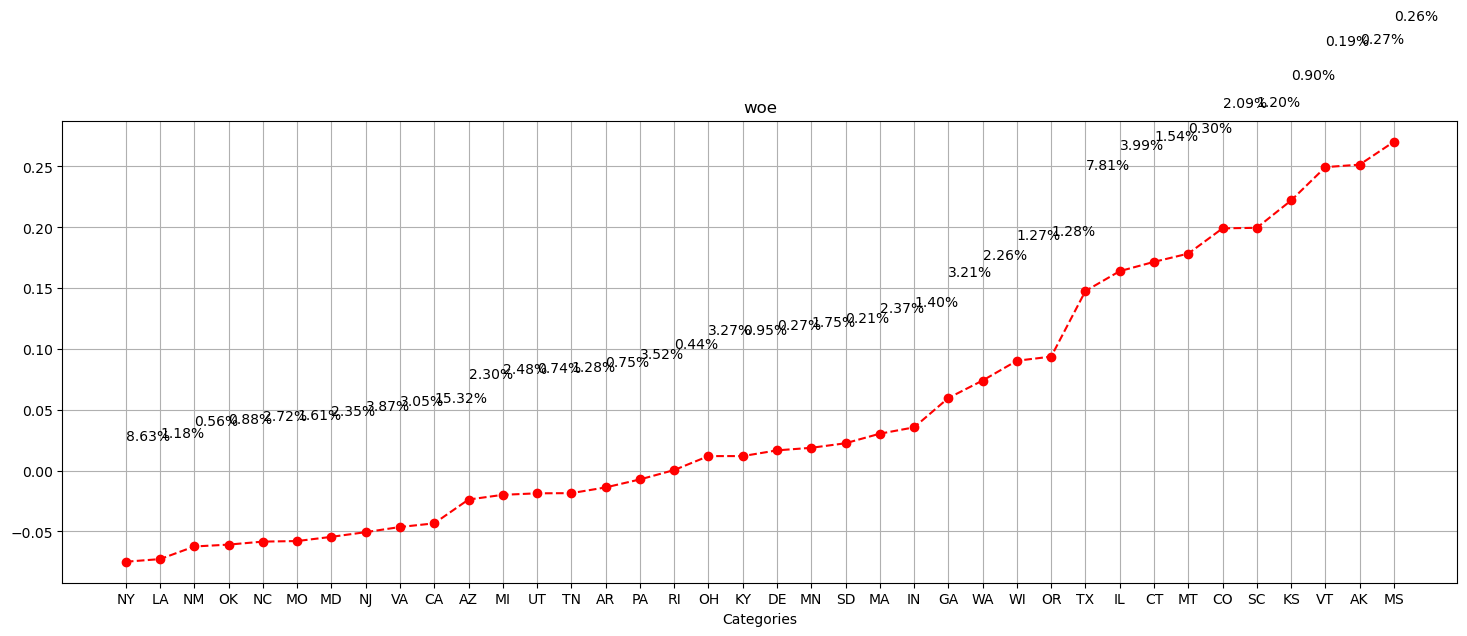

In [43]:
plot_woe(woe_summary.loc['addr_state', :].iloc[6:-6, :]['woe'],
         labels=woe_summary.loc['addr_state', :].iloc[6:-6, :]['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [44]:
states_groups.add_child(Group().add_child('NY')).add_child(Group().add_child('CA'))

In [45]:
states_groups.add_child(Group().extend_group(['NM', 'OK', 'NC', 'MO', 'MD', 'NJ', 'VA']))

In [46]:
states_groups.add_child(Group().extend_group(['AZ', 'MI', 'UT', 'TN', 'AR', 'PA']))\
            .add_child(Group().extend_group(['RI', 'OH', 'KY', 'DE', 'MN', 'SD', 'MA', 'IN']))          

In [47]:
states_groups.add_child(Group().extend_group(['GA', 'WA', 'WI', 'OR']))\
              .add_child(Group().add_child('TX'))

In [48]:
states_groups.add_child(Group().extend_group(['IL', 'MT', 'CT']))\
            .add_child(Group().extend_group(['MT', 'CO', 'SC', 'KS', 'VT', 'AK', 'MS']))

In [49]:
dft.add_child(states_groups)

In [50]:
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE
|	|----addr_state
|	|	|----NE_IA_ND_NV_HI_FL_AL
|	|	|	|----NE
|	|	|	|----IA
|	|	|	|----ND
|	|	|	|----NV
|	|	|	|----HI
|	|	|	|----FL
|	|	|	|----AL
|	|	|----ID_NH_WV_WY_DC_ME
|	|	|	|----ID
|	|	|	|----NH
|	|	|	|----WV
|	|	|	|----WY
|	|	|	|----DC
|	|	|	|----ME
|	|	|----NY
|	|	|	|----NY
|	|	|----CA
|	|	|	|----CA
|	|	|----NM_OK_NC_MO_MD_NJ_VA
|	|	|	|----NM
|	|	|	|----OK
|	|	|	|----NC
|	|	|	|----MO
|	|	|	|----MD
|	|	|	|----NJ
|	|	|	|----VA
|	|	|----AZ_MI_UT_TN_AR_PA
|	|	|	|----AZ
|	|	|	|----MI
|	|	|	|----UT
|	|	|	|----TN
|	|	|	|----AR
|	|	|	|----PA
|	|	|----RI_OH_KY_DE_MN_SD_MA_IN
|	|	|	|----RI
|	|	|	|----OH
|	|	|	|----KY
|	|	|	|--

**Verification status**

In [51]:
verification_groups = GroupedColumn('verification_status')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

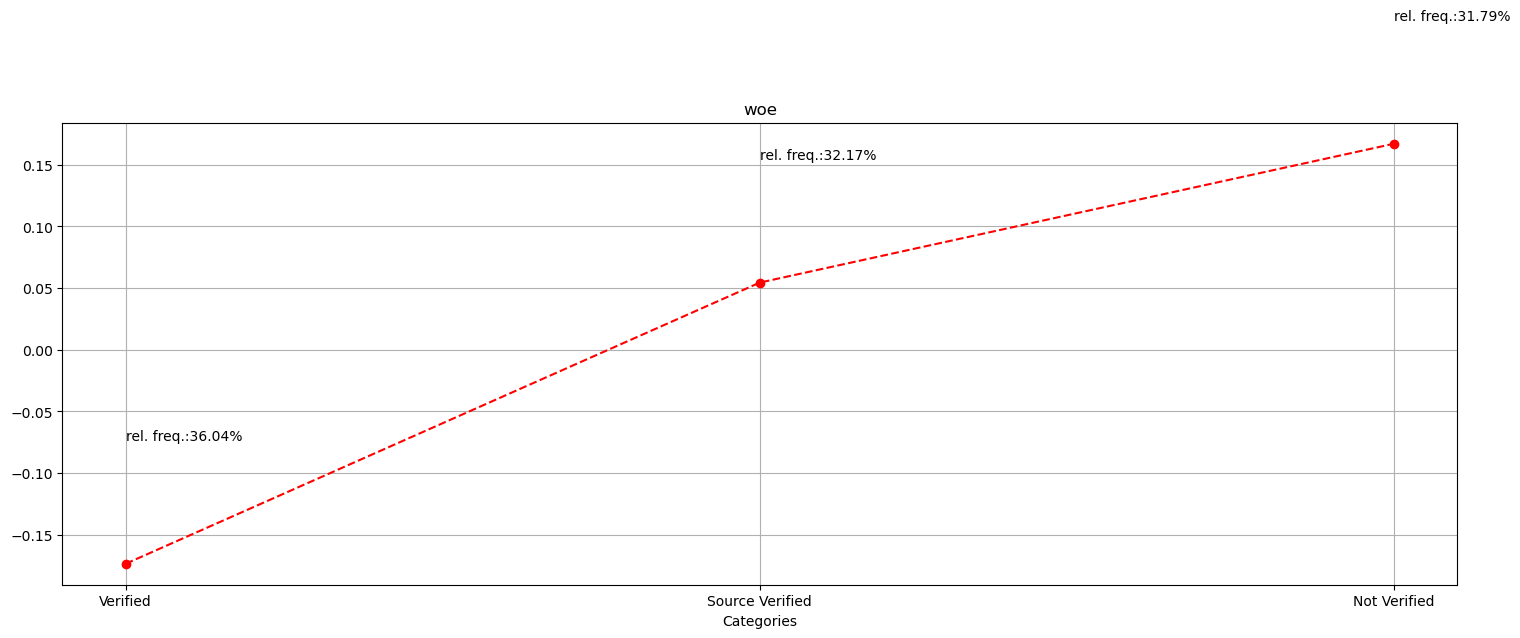

In [52]:
plot_woe(woe_summary.loc['verification_status', :]['woe'], labels=woe_summary.loc['verification_status', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [53]:
verification_groups.add_one_category_groups(woe_summary.loc['verification_status', :].index.to_list())

In [54]:
dft.add_child(verification_groups)

**Purpose**

In [55]:
purpose_groups = GroupedColumn('purpose')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

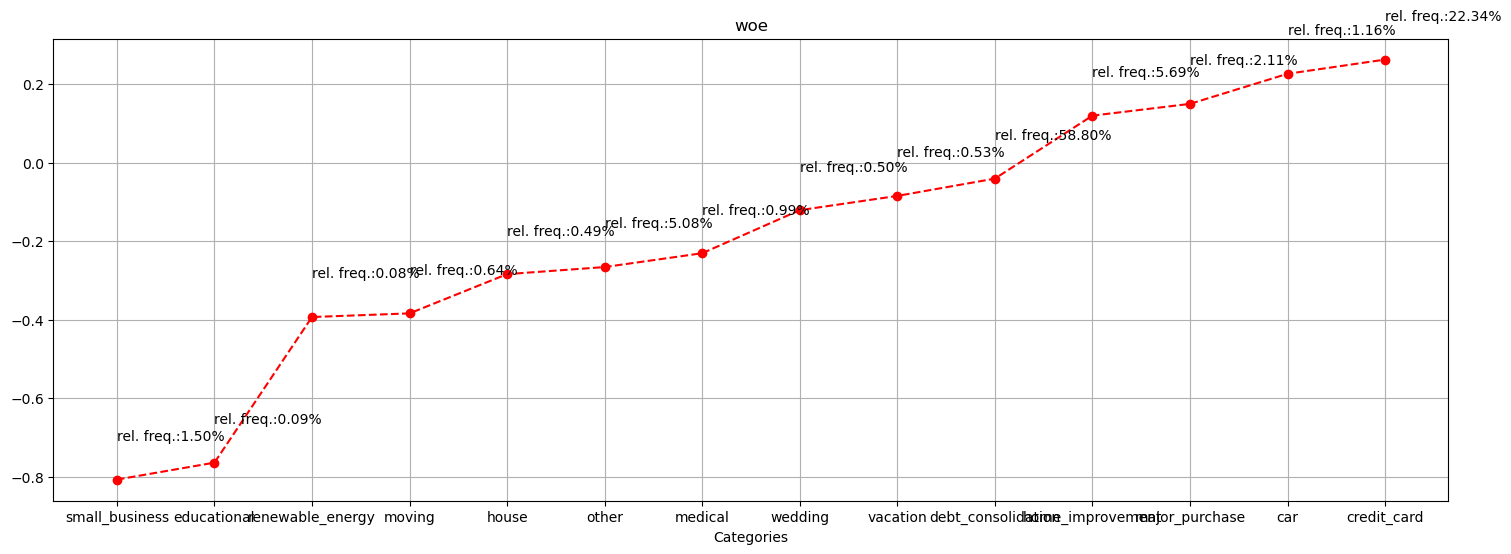

In [56]:
plot_woe(woe_summary.loc['purpose', :]['woe'], labels=woe_summary.loc['purpose', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{:.2%}'.format(v)))

In [57]:
purpose_groups.add_child(
        Group().extend_group(['educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house', 'other', 'medical', 'vacation'])
    ).add_child(
        Group().add_child('debt_consolidation')
    ).add_child(
        Group().extend_group(['major_purchase', 'car', 'home_improvement'])
    ).add_child(
        Group().add_child('credit_card')
    )

In [58]:
dft.add_child(purpose_groups)

**Initial List status**

In [59]:
initial_list_groups = GroupedColumn('initial_list_status')

In [60]:
woe_summary.loc['initial_list_status', :].head()

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
f,36454,266551,303005,0.649828,0.715233,0.641801,-0.108330,NaN,NaN,NaN,0.649828,0.024801
w,14514,148766,163280,0.350172,0.284767,0.358199,0.229417,0.283603,0.430466,0.337746,1.000000,0.024801


In [61]:
initial_list_groups.add_one_category_groups(['f', 'w'])

In [62]:
print(initial_list_groups)

|----initial_list_status
|	|----f
|	|	|----f
|	|----w
|	|	|----w



In [63]:
dft.add_child(initial_list_groups)

In [64]:
print(dft)

|----DataFrameTransform
|	|----grade
|	|	|----G_F_E
|	|	|	|----G
|	|	|	|----F
|	|	|	|----E
|	|	|----D
|	|	|	|----D
|	|	|----C
|	|	|	|----C
|	|	|----B
|	|	|	|----B
|	|	|----A
|	|	|	|----A
|	|----home_ownership
|	|	|----OTHER_NONE_ANY_RENT
|	|	|	|----OTHER
|	|	|	|----NONE
|	|	|	|----ANY
|	|	|	|----RENT
|	|	|----OWN
|	|	|	|----OWN
|	|	|----MORTGAGE
|	|	|	|----MORTGAGE
|	|----addr_state
|	|	|----NE_IA_ND_NV_HI_FL_AL
|	|	|	|----NE
|	|	|	|----IA
|	|	|	|----ND
|	|	|	|----NV
|	|	|	|----HI
|	|	|	|----FL
|	|	|	|----AL
|	|	|----ID_NH_WV_WY_DC_ME
|	|	|	|----ID
|	|	|	|----NH
|	|	|	|----WV
|	|	|	|----WY
|	|	|	|----DC
|	|	|	|----ME
|	|	|----NY
|	|	|	|----NY
|	|	|----CA
|	|	|	|----CA
|	|	|----NM_OK_NC_MO_MD_NJ_VA
|	|	|	|----NM
|	|	|	|----OK
|	|	|	|----NC
|	|	|	|----MO
|	|	|	|----MD
|	|	|	|----NJ
|	|	|	|----VA
|	|	|----AZ_MI_UT_TN_AR_PA
|	|	|	|----AZ
|	|	|	|----MI
|	|	|	|----UT
|	|	|	|----TN
|	|	|	|----AR
|	|	|	|----PA
|	|	|----RI_OH_KY_DE_MN_SD_MA_IN
|	|	|	|----RI
|	|	|	|----OH
|	|	|	|----KY
|	|	|	|--

#### Continuous Variables

In [65]:
continuous_vars: List[str] = [
    'term_int',
    'non_default',
    'emp_length_int',
    'months_since_issue_d'
]

In [66]:
continuous_df: pd.DataFrame = df[continuous_vars].copy()

In [67]:
continuous_dft = DataFrameTransform()

**Term int**

In [68]:
calculate_woe_iv(continuous_df, continuous_df['term_int'], continuous_df['non_default'], multilevel_index=False, sort_by_woe=False)

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
term_int,,,,,,,,,,,,
36,32810,305143,337953,0.724778,0.643737,0.734723,0.132203,NaN,NaN,NaN,0.724778,0.03886
60,18158,110174,128332,0.275222,0.356263,0.265277,-0.294894,0.469446,0.287474,0.427097,1.000000,0.03886


In [69]:
term_int_groups: GroupedColumn = GroupedColumn('term_int').add_one_category_groups(continuous_df['term_int'].unique().tolist())

In [70]:
continuous_dft.add_child(term_int_groups)

**Emp length int**

In [71]:
emp_length_groups = GroupedColumn('emp_length_int')

In [72]:
continuous_df['emp_length_int'].unique()

array([ 0,  2, 10,  9,  1,  3,  6,  8,  7,  4,  5], dtype=int8)

In [73]:
emp_length_woe = calculate_woe_iv(continuous_df, continuous_df['emp_length_int'], continuous_df['non_default'], multilevel_index=False, sort_by_woe=False)

In [74]:
emp_length_woe

non_default,0,1,n_obs,n_obs_rel,bad_rel,good_rel,woe,good_rel_diff,bad_rel_diff,woe_diff,accum_n_obs_rel,iv
emp_length_int,,,,,,,,,,,,
0,7101,50172,57273,0.122828,0.139323,0.120804,-0.142623,NaN,NaN,NaN,0.122828,0.006611
1,3314,26308,29622,0.063528,0.065021,0.063344,-0.026127,0.057460,0.074302,0.116496,0.186356,0.006611
2,4541,36832,41373,0.088729,0.089095,0.088684,-0.004624,0.025340,0.024074,0.021503,0.275085,0.006611
3,4008,32588,36596,0.078484,0.078638,0.078465,-0.002192,0.010219,0.010458,0.002432,0.353569,0.006611
4,3071,24952,28023,0.060098,0.060253,0.060079,-0.002893,0.018386,0.018384,0.000701,0.413668,0.006611
5,3538,27236,30774,0.065998,0.069416,0.065579,-0.056866,0.005499,0.009163,0.053973,0.479666,0.006611
6,3058,23054,26112,0.056000,0.059998,0.055509,-0.077766,0.010069,0.009418,0.020900,0.535666,0.006611
7,2915,23265,26180,0.056146,0.057193,0.056017,-0.020764,0.000508,0.002806,0.057002,0.591812,0.006611
8,2465,19930,22395,0.048029,0.048364,0.047987,-0.007810,0.008030,0.008829,0.012954,0.639840,0.006611


<Axes: title={'center': 'woe'}, xlabel='Categories'>

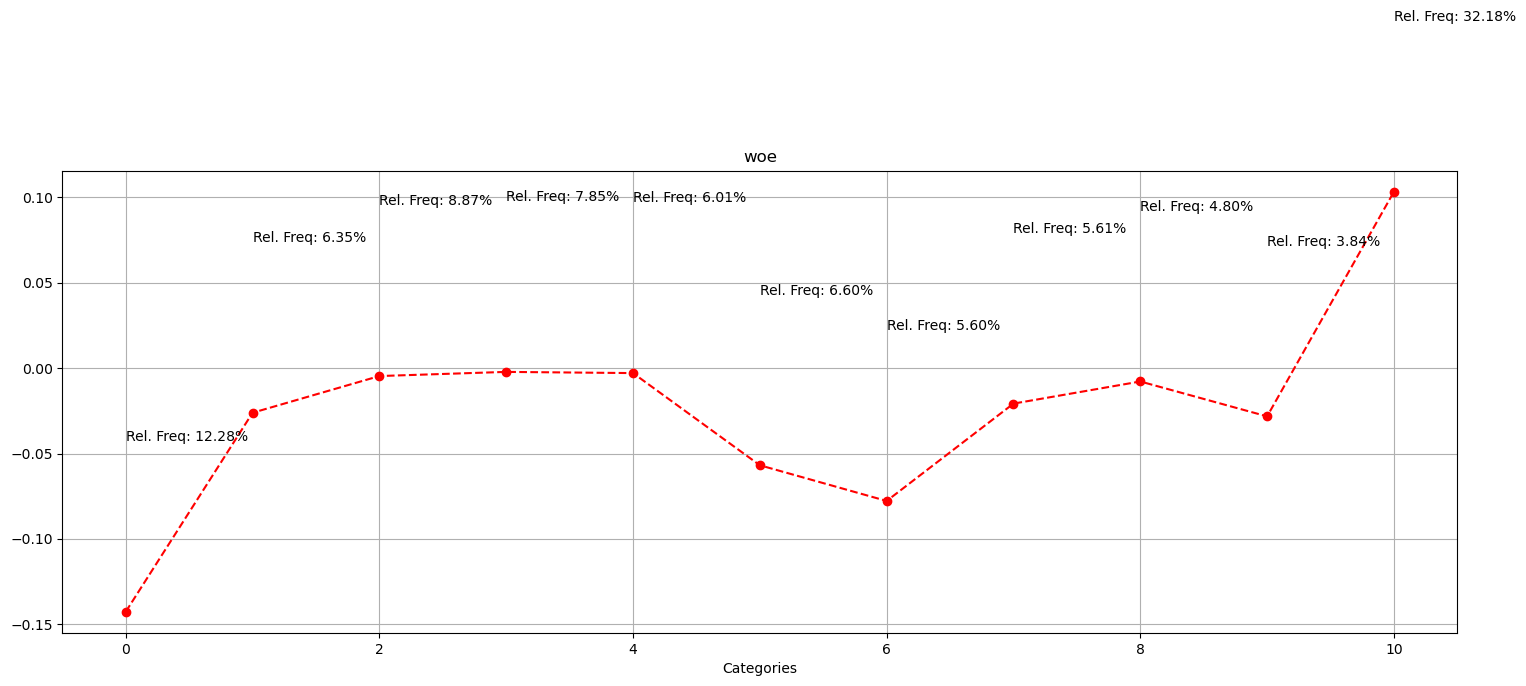

In [75]:
plot_woe(emp_length_woe['woe'], labels=emp_length_woe['n_obs_rel'].apply(lambda v: 'Rel. Freq: {:.2%}'.format(v)))

In [76]:
emp_length_groups.add_child(
        Group().add_child(0)
    ).add_child(
        Group().add_child(1)
    ).add_child(
        Group().extend_group([2, 3, 4])
    ).add_child(
        Group().extend_group([5, 6])
    ).add_child(
        Group().extend_group([7, 8, 9])
    ).add_child(
        Group().add_child(10)
    )

In [77]:
print(emp_length_groups)

|----emp_length_int
|	|----0
|	|	|----0
|	|----1
|	|	|----1
|	|----2_3_4
|	|	|----2
|	|	|----3
|	|	|----4
|	|----5_6
|	|	|----5
|	|	|----6
|	|----7_8_9
|	|	|----7
|	|	|----8
|	|	|----9
|	|----10
|	|	|----10



In [78]:
continuous_dft.add_child(emp_length_groups)

**Months since issue date**

In [79]:
m_issue_groups = GroupedColumn('months_since_issue_d')

In [80]:
BINS = 50

In [82]:
msid_woe = calculate_woe_iv(
                continuous_df,
                pd.cut(continuous_df['months_since_issue_d'], bins=BINS, retbins=False),
                continuous_df['non_default'], multilevel_index=False, sort_by_woe=False
)

<Axes: title={'center': 'woe'}, xlabel='Categories'>

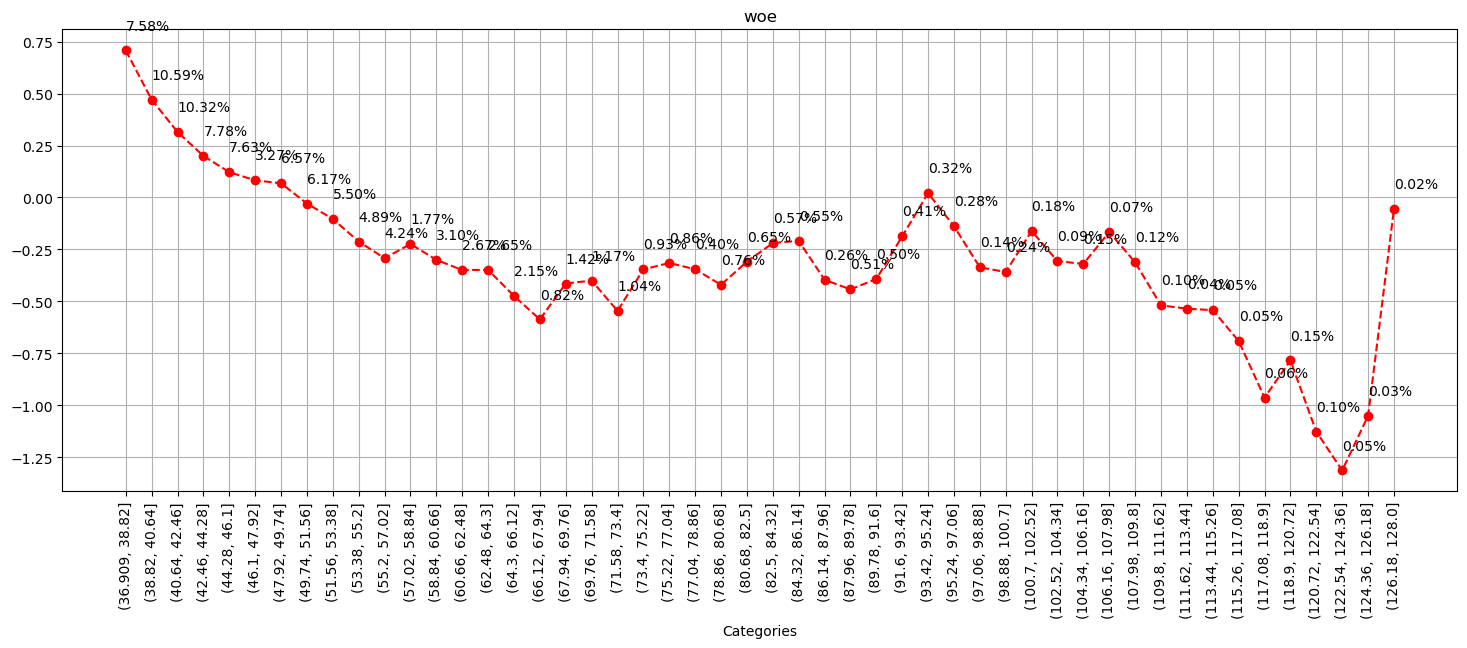

In [121]:
plot_woe(msid_woe['woe'], labels=msid_woe['n_obs_rel'].apply(lambda v: '{:.2%}'.format(v)))

In [122]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=-np.inf, right=38, closed='right'))
    )

In [123]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=38, right=40, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=40, right=42, closed='right'))
    )

<Axes: title={'center': 'woe'}, xlabel='Categories'>

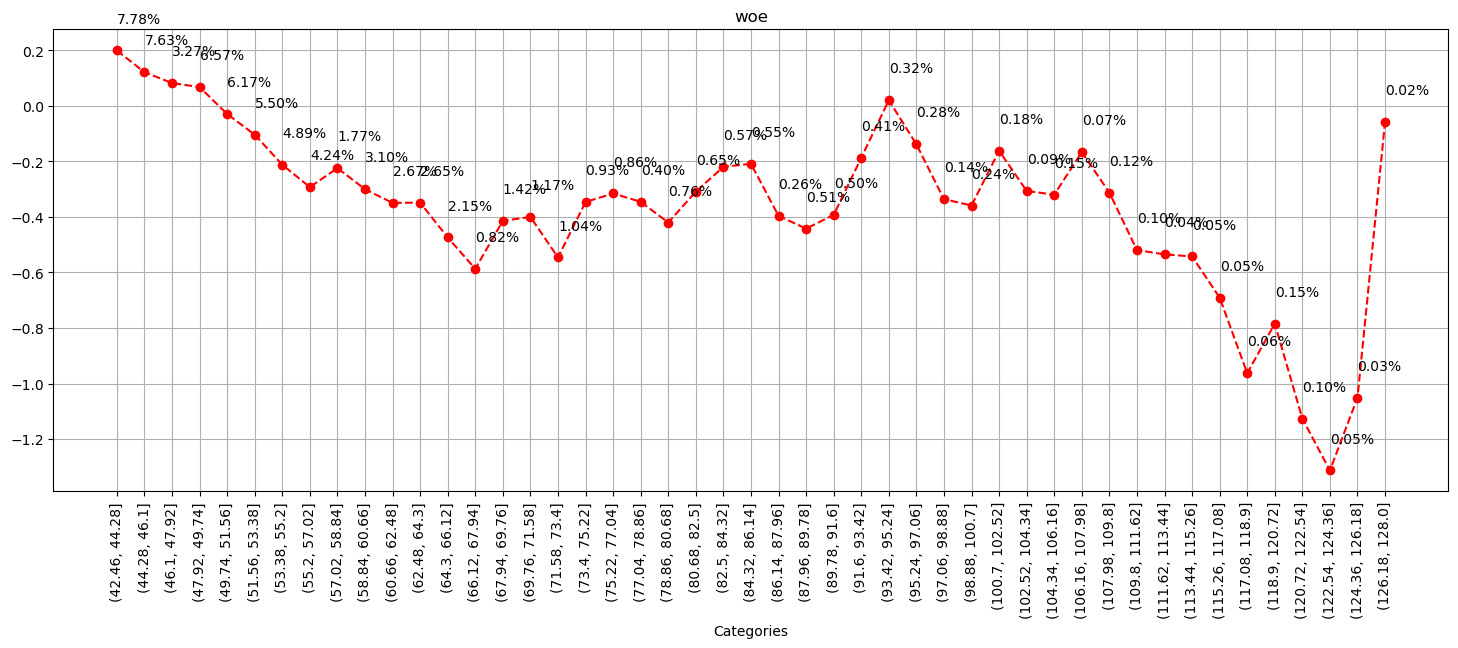

In [124]:
plot_woe(msid_woe['woe'].iloc[3:], labels=msid_woe['n_obs_rel'].iloc[3:].apply(lambda v: '{:.2%}'.format(v)))

In [125]:
m_issue_groups.add_child(
        Interval().add_child(pd.Interval(left=42, right=49, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=49, right=53, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=53, right=64, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=64, right=86, closed='right'))
    ).add_child(
        Interval().add_child(pd.Interval(left=86, right=np.inf, closed='right'))
    )

In [126]:
continuous_dft.add_child(m_issue_groups)